# Focal Loss for Dense Object Detection Code 구현

1. 사전 준비
*   Library 선언
*   Train Data 확보

2. Training Data 구축
- Data Transforms 정의
- Data Encoder 정의
- Data Loader 정의

3. Model 구축
- Resnet Backbone
- FPN
- RetinaNet 
- Pre-train 가중치 설정
- Loss Function(FocalLoss)

4. Model 학습
- train 



In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.1 MB/s 


# **Albumentations란? **
Albumentations는 Computer vision tool이다. 
Data Augmentation을 함에 있어 기존의 transform에 비해 훨씬더 시간이 빠르다.

# 관련자료 
* paper: https://www.mdpi.com/2078-2489/11/2/125
* github: https://github.com/albumentations-team/albumentations

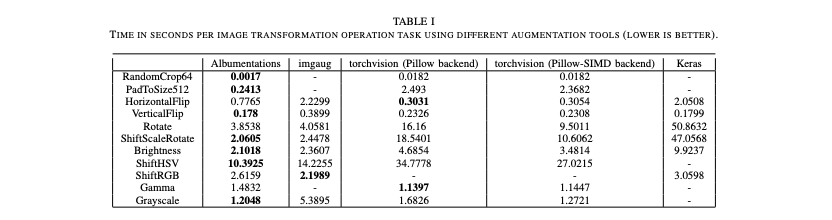


In [ ]:
#Albumentations is a computer vision tool that boosts the performance of deep convolutional neural networks.
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 117 kB 3.6 MB/s 
     |████████████████████████████████| 948 kB 29.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=1839a537e9dc1412a7f53b91159f20fbb34c850f520ed7943bcb2324ddf4e8ac
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# !pip install mmcv-full
# !pip install mmdet
# !git clone https://github.com/open-mmlab/mmdetection.git
# !cd mmdetection
# !pip install -r requirements/build.txt
# !pip install -v -e .  # or "python setup.py develop"

모델을 돌리기 위해 사용되는 라이브러리들을 선언해줍니다.

In [ ]:
# # Check Pytorch installation
# import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())

# # Check MMDetection installation
# import mmdet
# print(mmdet.__version__)

# # Check mmcv installation
# from mmcv.ops import get_compiling_cuda_version, get_compiler_version
# print(get_compiling_cuda_version())
# print(get_compiler_version())

1.10.0+cu111 True
2.20.0
11.1
GCC 7.5


In [ ]:
# # for instaboost
# !pip install instaboostfast
# # for panoptic segmentation
# !pip install git+https://github.com/cocodataset/panopticapi.git
# # for LVIS dataset
# !pip install git+https://github.com/lvis-dataset/lvis-api.git
# # for albumentations
# !pip install albumentations>=0.3.2 --no-binary imgaug,albumentations


In [ ]:
# !wget https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth

--2022-02-02 13:55:52--  https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152149505 (145M) [application/octet-stream]
Saving to: ‘retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth.1’

retinanet_r50_fpn_1 100%[===================>] 145.10M  11.4MB/s    in 13s     

2022-02-02 13:56:06 (11.3 MB/s) - ‘retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth.1’ saved [152149505/152149505]



In [ ]:
from torchvision.datasets import VOCDetection                       #Pascal VOD Data를 위한 라이브러리
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from PIL import Image, ImageDraw, ImageFont
import os
import xml.etree.ElementTree as ET                                  #XML 데이터를 구문 분리 라이브러리 TMI)보안 이슈로 Python 3.3부터 삭제
from typing import Any, Callable, Dict, Optional, Tuple, List       #변수를 만들어 줄 때 자료구조를 명시하기 위한 라이브러리
import warnings
import tarfile
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensor
import os
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VOC Data Set을 저장할 경로를 설정하고 폴더가 없는 경우 만들어줍니다

In [ ]:
path2data = '/content/voc'
if not os.path.exists(path2data):
    os.mkdir(path2data)

VOC Data Set에서 Custom Dataset을 만들기 위해 Class를 지정해줍니다

In [ ]:
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa", 
    "train",
    "tvmonitor"
]

VOC Data Set XML Data 형태 설명
구조
* ─ Annotations  : JPEGImages에 담겨있는 이미지 oject detection을 위한 정답 데이터. 
* ─ ImageSets : 특정 클래스가 어떤 이미지에 있는지 등에 대한 정보를 포함하는 폴더

* ─ JPEGImages : object dectection을 위한 입력 데이터. 이미지 파일이 모여있습니다

* ─ SegmentationClass : Semantic segmentation을 학습하기위한 label 이미지들

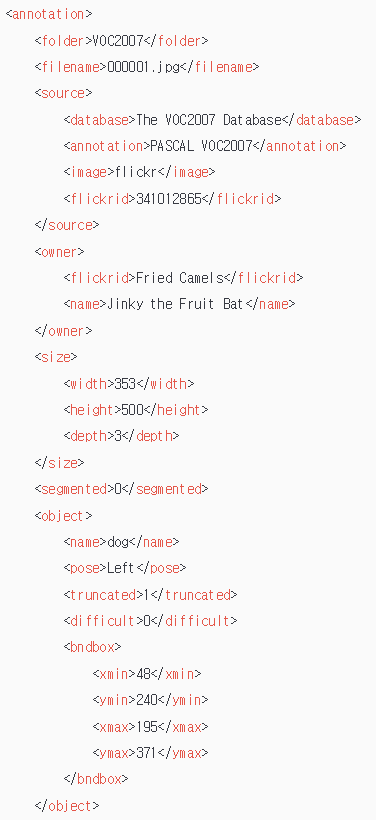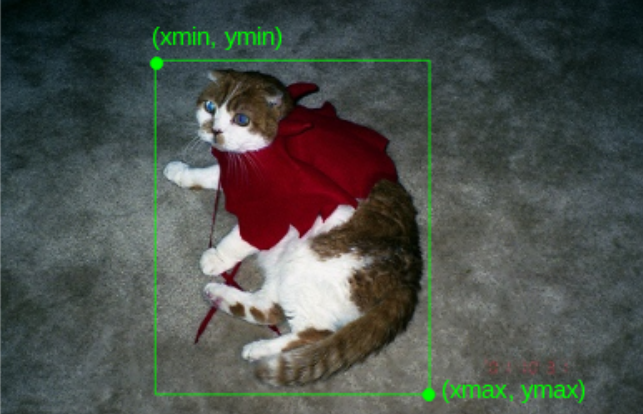

In [ ]:
# PyTorch에서 제공하는 VOC dataset을 상속받아, custom dataset을 생성합니다.
class myVOCDetection(VOCDetection):
    def __getitem__(self, index):
        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot()) # xml파일 분석하여 dict으로 받아오기

        targets = [] # 바운딩 박스 좌표
        labels = [] # 바운딩 박스 클래스

        # 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])

            targets.append(list(label[:4])) # 바운딩 박스 좌표
            labels.append(label[4])         # 바운딩 박스 클래스

        if self.transforms:
            augmentations = self.transforms(image=img, bboxes=targets)
            img = augmentations['image']
            targets = augmentations['bboxes']

        return img, targets, labels

    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]: # xml 파일을 dictionary로 반환
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v) #ind = xmin, v = 48
                    
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

Train, Validation dataset을 다운로드하고 생성합니다.

In [ ]:
# train, validation dataset을 생성합니다.
# path2data = '/content/voc'
train_ds = myVOCDetection(path2data, year='2007', image_set='train', download=True)
val_ds = myVOCDetection(path2data, year='2007', image_set='test', download=True)

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting /content/voc/VOCtrainval_06-Nov-2007.tar to /content/voc


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting /content/voc/VOCtest_06-Nov-2007.tar to /content/voc


앞서 Loading한 이미지 중에서 랜덤하게 1개를 선택합니다

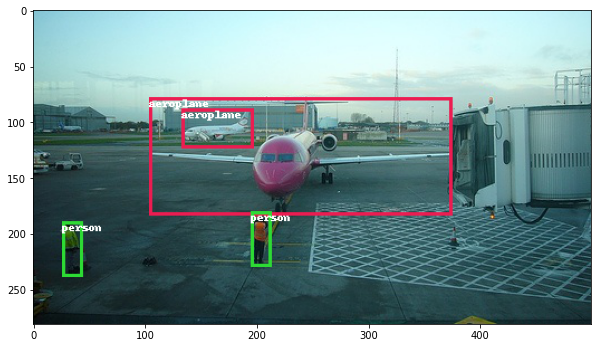

In [ ]:
# 샘플 이미지 확인
img, target, label = train_ds[4]
colors = np.random.randint(0, 255, size=(80,3), dtype='uint8') # 바운딩 박스 색상

# 시각화 함수
def show(img, targets, labels, classes=classes):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    W, H = img.size

    for tg,label in zip(targets,labels):
        id_ = int(label) # class
        bbox = tg[:4]    # [xmin, ymin, xmax, ymax]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        #Bounding Box
        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])), outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]), name, fill=(255,255,255,0))
    plt.imshow(np.array(img))

plt.figure(figsize=(10,10))
show(img, target, label)

Data Image를 Augmentation 합니다

In [ ]:
# transforms 정의
IMAGE_SIZE = 600
scale = 1.0

# 이미지에 padding을 적용하여 종횡비를 유지시키면서 크기가 600x600 되도록 resize 합니다.
train_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    #PadIfNeeded : min_size보다 작으면
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensor()
                    ],
                    # (x1, y1, x2, y2) -> (cx, cy, w, h)
                    # min_visibility : Data Augmentation시 객체가 짤리거나 작아지는 경우에 따른 Bounding 축소비율 
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

val_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensor()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

# transforms 적용하기
train_ds.transforms = train_transforms
val_ds.transforms = val_transforms

논문에서 말한 Anchor를 설정하고 만들어주는 부분

In [ ]:
class DataEncoder:
    def __init__(self):
        self.anchor_areas = [32*32., 64*64., 128*128., 256*256., 512*512.] # 피쳐맵 크기 p3 -> p7
        self.aspect_ratios = [1/2., 1/1., 2/1.]                            # 앵커 박스 종횡비, w/h
        self.scale_ratios = [1., pow(2,1/3.), pow(2,2/3.)]                 # 앵커 박스 scale
        self.anchor_wh = self._get_anchor_wh()                             # 5개의 피쳐맵 각각에 해당하는 9개의 앵커 박스 생성 

    # 각 피쳐맵에서 사용할 앵커 박스 높이와 넓이를 계산
    def _get_anchor_wh(self):
      
        anchor_wh = []
        for s in self.anchor_areas: # 각 피쳐맵 크기 추출

            for ar in self.aspect_ratios: # ar = w/h
                h = math.sqrt(s/ar)
                w = ar * h

                for sr in self.scale_ratios: # scale
                    anchor_h = h*sr
                    anchor_w = w*sr
                    anchor_wh.append([anchor_w, anchor_h])

        num_fms = len(self.anchor_areas)
        return torch.Tensor(anchor_wh).view(num_fms, -1, 2) # [#fms, #anchors_pre_cell, 2], [5, 9, 2]

    def _get_anchor_boxes(self, input_size):
        # 피쳐맵의 모든 cell에 앵커 박스 할당
        num_fms = len(self.anchor_areas) # 5

        #각 피쳐맵 Stride 수만큼 크기 축소하려면 32~512 -> i가 2~6여야 되는 것 아닌지 의문
        fm_sizes = [(input_size/pow(2.,i+3)).ceil() for i in range(num_fms)] # 각 피쳐맵 stride 만큼 입력 크기 축소

        boxes = []
        for i in range(num_fms): # p3 ~ p7
            fm_size = fm_sizes[i] # i 번째 피쳐맵 크기 추출
            grid_size = input_size / fm_size # 입력 크기를 피쳐맵 크기로 나누어 grid size 생성
            fm_w, fm_h = int(fm_size[0]), int(fm_size[1]) #600/32 x 600/32이 들어옴
            xy = self._meshgrid(fm_w, fm_h) + 0.5 #[fm_h * fm_w, 2] 피쳐맵 cell index 생성

            xy = (xy*grid_size).view(fm_h, fm_w, 1, 2).expand(fm_h, fm_w, 9, 2) # anchor 박스 좌표
            wh = self.anchor_wh[i].view(1,1,9,2).expand(fm_h, fm_w, 9, 2) # anchor 박스 높이와 너비
            box = torch.cat([xy,wh],3) # [x,y,w,h]
            boxes.append(box.view(-1,4))
        return torch.cat(boxes, 0)

    # cell index 생성 함수
    def _meshgrid(self, x, y, row_major=True):
        a = torch.arange(0,x)         # 0 ~ 600/32
        b = torch.arange(0,y)         # 0 ~ 600/32
        xx = a.repeat(y).view(-1,1)   # (0, 0~600/32),(1, 0~600/32),....)
        yy = b.view(-1,1).repeat(1,x).view(-1,1) # (0~600/32, 0),(0~600/32, 1),....)
        return torch.cat([xx,yy],1) if row_major else torch.cat([yy,xx],1)

    # x1,y1,x2,y2 <-> cx,cy,w,h
    def _change_box_order(self, boxes, order):
        assert order in ['xyxy2xywh','xywh2xyxy']
        boxes = np.array(boxes)
        a = boxes[:,:2]
        b = boxes[:,2:]
        a, b = torch.Tensor(a), torch.Tensor(b)
        if order == 'xyxy2xywh':
            return torch.cat([(a+b)/2,b-a+1],1) # xywh
        return torch.cat([a-b/2, a+b/2],1) # xyxy

    # 두 박스의 iou 계산
    def _box_iou(self, box1, box2, order='xyxy'):
        if order == 'xywh':
            box1 = self._change_box_order(box1, 'xywh2xyxy')
            box2 = self._change_box_order(box2, 'xywh2xyxy')
        
        N = box1.size(0)
        M = box2.size(0)

        lt = torch.max(box1[:,None,:2], box2[:,:2])
        rb = torch.min(box1[:,None,2:], box2[:,2:])

        wh = (rb-lt+1).clamp(min=0)
        inter = wh[:,:,0] * wh[:,:,1]

        area1 = (box1[:,2]-box1[:,0]+1) * (box1[:,3]-box1[:,1]+1)
        area2 = (box2[:,2]-box2[:,0]+1) * (box2[:,3]-box2[:,1]+1)
        iou = inter / (area1[:,None] + area2 - inter)
        return iou

    # 피쳐맵의 각 셀에 anchor 박스 생성하고, positive와 negative 할당
    def encode(self, boxes, labels, input_size):
        input_size = torch.Tensor([input_size, input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size) # 앵커 박스 생성
        boxes = self._change_box_order(boxes, 'xyxy2xywh') # xyxy -> cxcywh

        ious = self._box_iou(anchor_boxes, boxes, order='xywh') # ground-truth와 anchor의 iou 계산
        max_ious, max_ids = ious.max(1) # 가장 높은 iou를 지닌 앵커 추출
        boxes = boxes[max_ids]

        # 앵커 박스와의 offset 계산
        # Max IoU x,y좌표-anchor x,y좌표/넓이깊이
        loc_xy = (boxes[:,:2]-anchor_boxes[:,:2]) / anchor_boxes[:,2:]
        loc_wh = torch.log(boxes[:,2:]/anchor_boxes[:,2:])
        loc_targets = torch.cat([loc_xy, loc_wh], 1)

        # class 할당
        cls_targets = 1 + labels[max_ids]
        cls_targets[max_ious<0.5] = 0 # iou < 0.5 anchor는 negative
        ignore = (max_ious>0.4) & (max_ious<0.5) # [0.4,0.5] 는 무시
        cls_targets[ignore] = -1
        return loc_targets, cls_targets

    # encode된 값을 원래대로 복구 및 nms 진행
    def decode(self,loc_preds, cls_preds, input_size):
        cls_thresh = 0.5
        nms_thresh = 0.5

        input_size = torch.Tensor([input_size,input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size) # 앵커 박스 생성

        loc_xy = loc_preds[:,:2] # 결과값 offset 추출
        loc_wh = loc_preds[:,2:]

        xy = loc_xy * anchor_boxes[:,2:] + anchor_boxes[:,:2] # offset + anchor
        wh = loc_wh.exp() * anchor_boxes[:,2:]
        boxes = torch.cat([xy-wh/2, xy+wh/2], 1)

        score, labels = cls_preds.sigmoid().max(1)
        ids = score > cls_thresh
        ids = ids.nonzero().squeeze()
        keep = self._box_nms(boxes[ids], score[ids], threshold=nms_thresh) # nms
        return boxes[ids][keep], labels[ids][keep]

  
    # 가장 예측 확률이 높은 값을 빼고 다른 Box는 제외
    def _box_nms(self, bboxes, scores, threshold=0.5, mode='min'):
        x1 = bboxes[:,0]
        y1 = bboxes[:,1]
        x2 = bboxes[:,2]
        y2 = bboxes[:,3]

        areas = (x2-x1+1) * (y2-y1+1)
        _, order = scores.sort(0, descending=True) # confidence 순 정렬
        keep = []
        while order.numel() > 0:
            if order.numel() == 1:
                keep.append(order.data)
                break
            i = order[0] # confidence 가장 높은 anchor 추출
            # print(i)
            keep.append(i) # 최종 detection에 저장

            xx1 = x1[order[1:]].clamp(min=x1[i])
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])

            w = (xx2-xx1+1).clamp(min=0)
            h = (yy2-yy1+1).clamp(min=0)
            inter = w*h

            if mode == 'union':
                ovr = inter / (areas[i] + areas[order[1:]] - inter)
            elif mode == 'min':
                ovr = inter / areas[order[1:]].clamp(max=areas[i])
            else:
                raise TypeError('Unknown nms mode: %s.' % mode)

            ids = (ovr<=threshold).nonzero().squeeze()
            if ids.numel() == 0:
                break
            order = order[ids+1]
        return torch.LongTensor(keep)

Image를 Batch별로 불러와서 Encoding해주는 부분

In [ ]:
# collate_fn
# targets에 encode를 수행하고, tensor로 변경합니다.
def collate_fn(batch):
    encoder = DataEncoder()
    imgs = [x[0] for x in batch]
    boxes = [torch.Tensor(x[1]) for x in batch]
    labels = [torch.Tensor(x[2]) for x in batch]
    h,w = 600, 600
    num_imgs = len(imgs)
    inputs = torch.zeros(num_imgs, 3, h, w)

    loc_targets = []
    cls_targets = []
    for i in range(num_imgs):
        inputs[i] = imgs[i]
        loc_target, cls_target = encoder.encode(boxes=boxes[i], labels=labels[i], input_size=(w,h))
        loc_targets.append(loc_target)
        cls_targets.append(cls_target)
    return inputs, torch.stack(loc_targets), torch.stack(cls_targets)

Train과 Validation을 위한 DataLoader 부분

collate_fn : 샘플 목록을 병합하여 Tensor의 미니 배치를 형성합니다.

In [ ]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)

FPN에 들어가는 ResNetBottleNeck 선언부분


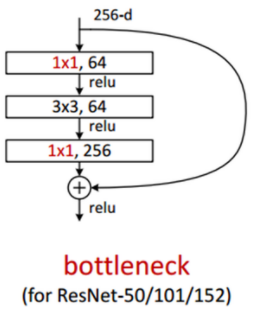

In [ ]:
# BottleNeck of ResNet
class Bottleneck(nn.Module):
    expand = 4

    def __init__(self, in_channels, inner_channels, stride=1):
        super().__init__()
        #in_channels = 64
        #inner_channels = 64/128/256/512 -> 256/512/1024/2048
        #Image Size 동일
        self.conv1 = nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(inner_channels)
        self.conv2 = nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        self.conv3 = nn.Conv2d(inner_channels, inner_channels*self.expand, 1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(inner_channels*self.expand)
        self.relu = nn.ReLU()

        self.downsample = nn.Sequential()

        #stride = 2 인 경우에 Image Size 절반으로 줄임
        if stride != 1 or in_channels != inner_channels*self.expand:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, inner_channels*self.expand, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels*self.expand)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.bn1(self.conv1(x)))
        output = self.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))
        output = self.relu(output + self.downsample(x))

        return output

# check
# def test():
#     x = torch.randn(1, 56,13,13).to(device)
#     net = Bottleneck(x.size(1), x.size(1)).to(device)
#     output = net(x)
#     print(output.size())

# test()

RetinaNet에 들어가는 FPN 부분

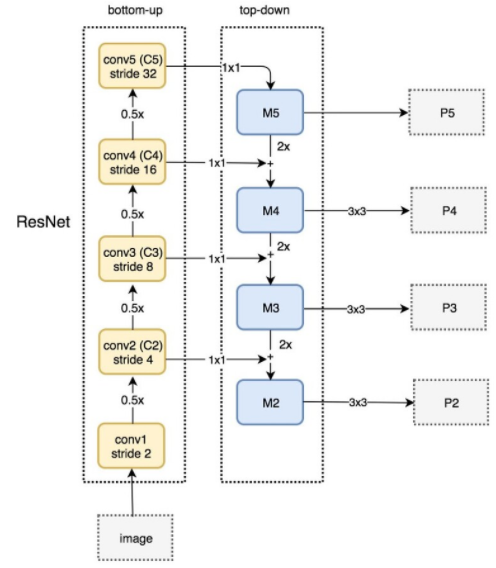

In [ ]:
# FPN은 ResNet의 피쳐맵에서 multi-scale로 특징을 추출합니다.
class FPN(nn.Module):
    def __init__(self, num_blocks):
        super(FPN, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False) # 300x300
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1) # 150x150

        # Bottom-up layers and ResNet
        # PyTorch 공식 홈페이지 ResNet 구현 코드와 변수명이 동일해야, pre-trained model을 불러와서 사용할 수 있습니다.
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)  # c2 150x150
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2) # c3 75x75
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2) # c4 38x38
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2) # c5 20x20
        
        self.conv6 = nn.Conv2d(2048, 256, 3, stride=2, padding=1)    # p6 20x20
        self.conv7 = nn.Sequential(                                  # p7 20x20
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1)
        )

        # Lateral layers
        self.lateral_1 = nn.Conv2d(2048, 256, 1, stride=1, padding=0)
        self.lateral_2 = nn.Conv2d(1024, 256, 1, stride=1, padding=0)
        self.lateral_3 = nn.Conv2d(512, 256, 1, stride=1, padding=0)

        # Top-down layers
        self.top_down_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.top_down_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        self.upsample_1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample_2 = nn.Upsample(size=(75,75), mode='bilinear', align_corners=False) # size=(75,75)를 지정해야 합니다.

    def forward(self, x):
        # Feature extractor(ResNet)
        c1 = self.relu(self.bn1(self.conv1(x)))
        c1 = self.maxpool(c1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        # FPN
        p6 = self.conv6(c5)
        p7 = self.conv7(p6)

        p5 = self.lateral_1(c5)

        p4 = self.top_down_1(self.upsample_1(p5) + self.lateral_2(c4))
        p3 = self.top_down_2(self.upsample_2(p4) + self.lateral_3(c3))

        return p3, p4, p5, p6, p7

    #의문점! Down Sampling을 위해 중간에 Stride = 2인 부분은 이해가나 뒤에 Stride = 1의 갯수가 다른 것은 의문점
    def _make_layer(self, inner_channels, num_block, stride):
        strides = [stride] + [1] * (num_block-1) #[1,1,1], [2,1,1,1], [2,1,1,1,1,1], [2,1,1]
        layers = []
        for stride in strides:
            layers.append(Bottleneck(self.in_channels, inner_channels, stride=stride))
            self.in_channels = inner_channels*Bottleneck.expand
        return nn.Sequential(*layers)

def FPN50(): # ResNet-50
    return FPN([3,4,6,3])

# check
# if __name__ == '__main__':
#     x = torch.randn(3, 3, 600, 600).to(device)
#     model = FPN50().to(device)
#     outputs = model(x)
#     for output in outputs:
#         print(output.size())

RetinaNet의 전체 실행 Class

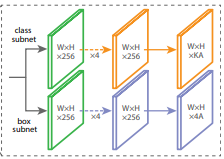

In [ ]:
# FPN 출력값을 입력으로 받아 예측을 수행합니다.
class RetinaNet(nn.Module):
    num_anchors = 9

    def __init__(self, num_classes=20):
        super().__init__()
        self.fpn = FPN50()
        self.num_classes = num_classes
        self.loc_head = self._make_head(self.num_anchors*4) # 바운딩 박스 좌표 예측
        self.cls_head = self._make_head(self.num_anchors*self.num_classes) # 바운딩 박스 클래스 예측

    def forward(self, x):
        # p3: batch, channels, H, W
        fms = self.fpn(x) # p3, p4, p5, p6, p7
        loc_preds = []
        cls_preds = []
        for fm in fms: # fpn 출력값에 classifier 추가
            loc_pred = self.loc_head(fm)
            cls_pred = self.cls_head(fm)
            loc_pred = loc_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,4)  # [N, 9*4,H,W] -> [N,H,W, 9*4] -> [N,H*W*9, 4]
            cls_pred = cls_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,self.num_classes) # [N,9*20,H,W] -> [N,H,W,9*20] -> [N,H*W*9,20]
            loc_preds.append(loc_pred)
            cls_preds.append(cls_pred)
        return torch.cat(loc_preds,1), torch.cat(cls_preds,1)

    def _make_head(self, out_channels): # 예측을 수행하는 Layer 생성 논문에 Layer 4
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(256,256,3, stride=1, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.Conv2d(256, out_channels, 3, stride=1, padding=1)) # (batch,9*4,H,W) or (batch,9*20,H,W) 
        return nn.Sequential(*layers)

    def freeze_bn(self): # pre-trained model을 사용하므로, BN freeze
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

# check
# if __name__ == '__main__':
#     x = torch.randn(10,3,600,600).to(device)
#     model = RetinaNet().to(device)
#     loc_preds, cls_preds = model(x)
#     print(loc_preds.size()) # (batch, 5 * H*W * 9, 4)
#     print(cls_preds.size()) # (batch, 5 * H*W * 9, 20)

사전에 학습된 Pretrained 모델의 가중치를 받아옵니다.

In [ ]:
# 사전 학습된 ResNet50의 가중치 다운로드 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
!wget 'https://download.pytorch.org/models/resnet50-19c8e357.pth'

--2022-02-04 04:36:08--  https://download.pytorch.org/models/resnet50-19c8e357.pth
Resolving download.pytorch.org (download.pytorch.org)... 13.35.162.25, 13.35.162.55, 13.35.162.16, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.162.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102502400 (98M) [application/octet-stream]
Saving to: ‘resnet50-19c8e357.pth’

resnet50-19c8e357.p 100%[===================>]  97.75M  92.5MB/s    in 1.1s    

2022-02-04 04:36:09 (92.5 MB/s) - ‘resnet50-19c8e357.pth’ saved [102502400/102502400]



Pretrained Model의 가중치를 갖고오는 부분

Pretrained된 ResNet50의 가중치 파일을 갖고와서
FPN에 사용되는 ResNet50 BottleNeck부분의 가중치로 덮어씌워준다.
그리고 RetinaNet내부 Model의 가중치들을 초기화 해주고
RetinaNet에 앞서 가져온 FPN 가중치를 적용시킨다.

In [ ]:
# 가중치 변경
path2weight = '/content/resnet50-19c8e357.pth' # 가중치 저장할 경로
d = torch.load(path2weight) # 사전학습 가중치 읽어오기
fpn = FPN50()               # FPN50 생성
dd = fpn.state_dict()       # fpn 가중치 파일 추출
for k in d.keys():          # 사전학습 가중치로부터 가중치 추출
    if not k.startswith('fc'): # fc layer 제외
        dd[k] = d[k]        # 변수 명이 동일한 경우, 가중치 받아오기

model = RetinaNet()         # RetinaNet 가중치 초기화
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

pi = 0.01
init.constant_(model.cls_head[-1].bias, -math.log((1-pi)/pi))

model.fpn.load_state_dict(dd)  # fpn의 가중치를 사전 학습된 가중치로 변경
torch.save(model.state_dict(), 'model.pth') # 가중치 저장

Data의 Class를 One-Hot Encoding하는 부분으로 주의깊게 볼만한 사항은 없습니다.

In [ ]:
# labels를 one-hot 형식으로 변경
def one_hot_embedding(labels, num_classes):
    # labels: class labels, sized [N,]
    # num_classes: 클래스 수 20
    y = torch.eye(num_classes) # [20, 20]
    np_labels = np.array(labels)
    return y[np_labels]


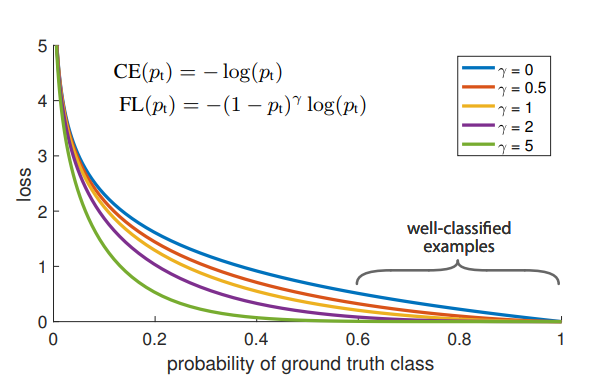

Alternative FocalLoss

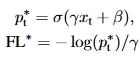

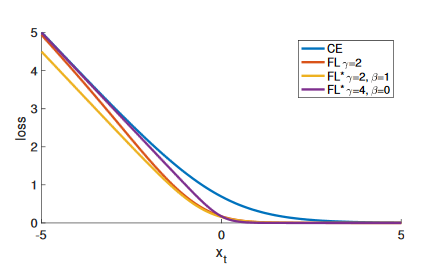

Focal Loss의 선언 부분

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.num_classes = num_classes # VOC dataset 20

    # alternative focal loss
    def focal_loss_alt(self, x, y):

        #기존 Loss
        # alpha = 0.25
        # gamma = 2

        # t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)  # [N,21]
        # t = t[:,1:]  # exclude background
        # t = Variable(t).cuda()  # [N,20]

        # p = x.sigmoid()
        # pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        # w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        # w = w * (1-pt).pow(gamma)
        # return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

        #Alternative Loss
        alpha = 0.25
        gamma = 2
        Betta = 1

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)
        t = t[:,1:] # 배경 제외
        t = t.cuda()

        xt = x*(2*t-1) # xt = x if t > 0 else -x
        pt = (gamma*xt+Betta).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / gamma
        return loss.sum()

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        # (loc_preds, loc_targets)와 (cls_preds, cls_targets) 사이의 loss 계산
        # loc_preds: [batch_size, #anchors, 4]
        # loc_targets: [batch_size, #anchors, 4]
        # cls_preds: [batch_size, #anchors, #classes]
        # cls_targets: [batch_size, #anchors]

        # loss = SmoothL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets)

        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0
        num_pos = pos.data.long().sum()

        # 객체가 존재하는 앵커박스의 Loss
        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        mask = pos.unsqueeze(2).expand_as(loc_preds) # [N, #anchors, 4], 객체가 존재하는 앵커박스 추출
        masked_loc_preds = loc_preds[mask].view(-1,4)      # [#pos, 4]
        masked_loc_targets = loc_targets[mask].view(-1, 4) # [#pos, 4]
        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, reduction='sum')

        # Classification의 Loss
        # cls_loss = FocalLoss(loc_preds, loc_targets)
        pos_neg = cls_targets > -1 # ground truth가 할당되지 않은 anchor 삭제
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1, self.num_classes)
        cls_loss = self.focal_loss_alt(masked_cls_preds, cls_targets[pos_neg])

        # print('loc_loss: %.3f | cls_loss: %.3f' % (loc_loss.item(), cls_loss))
        loss = (loc_loss+cls_loss)/num_pos
        return loss

L2의 경우 제곱식이므로 Location 4가지의 오차가 클수록 Loss가 과하게 커지므로 L1을 사용하며, 일반 L1에서는 미분이 되지 않는 곳이 있어
Backpropagation이 원활하게 되기위해 Smooth형태의 L1 사용



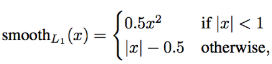

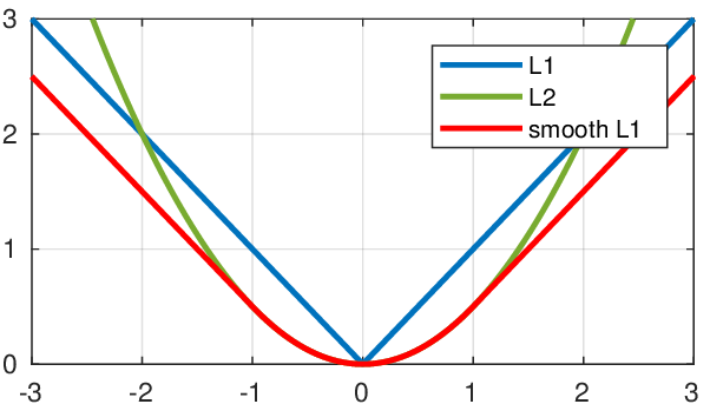

Optimizer와 Loss를 사용하는 부분
ReduceLROnPlateau는 학습률이 개선되지 않을 때 동적으로 학습률을 계산하여 조절하는 효과를 줍니다

In [ ]:
loss_func = FocalLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
#
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=15)

# 현재 lr 계산
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# batch당 loss 계산
def loss_batch(loss_func, loc_preds, loc_targets, cls_preds, cls_targets, opt=None):
    loss_b = loss_func(loc_preds, loc_targets, cls_preds, cls_targets)
    
    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item()

# epoch당 loss 계산
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    len_data = len(dataset_dl.dataset)

    for img, loc_targets, cls_targets in dataset_dl:
        img, loc_targets, cls_targets = img.to(device), loc_targets.to(device), cls_targets.to(device)
        loc_preds, cls_preds = model(img)

        loss_b = loss_batch(loss_func, loc_preds, loc_targets, cls_preds, cls_targets, opt)
        
        running_loss += loss_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    return loss

Model Train 함수 정의부분으로 특별히 알아볼만한 부분은 없습니다.

In [ ]:
# 학습을 시작하는 함수
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}

    best_loss = float('inf')
    torch.save(model.state_dict(), path2weights)
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)

        if current_lr != get_lr(opt):
            print('Loading best model weights')
            model.load_state_dict(torch.load(path2weights))

        print('train loss: %.6f, val loss: %.6f, time: %.4f min' %(train_loss, val_loss, (time.time()-start_time)/60))

    model.load_state_dict(torch.load(path2weights))
    return model, loss_history

Model의 Train Parameter를 설정하는 부분입니다.

In [ ]:
# train 파라미터 정의
params_train = {
    'num_epochs': 2,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# 가중치 저장할 폴더 생성
import os
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
model= RetinaNet().to(device)
model, loss_hist = train_val(model, params_train)

Epoch 0/1, current lr = 0.001
Copied best model weights!
train loss: 120.995989, val loss: 124.349217, time: 9.4498 min
Epoch 1/1, current lr = 0.001
train loss: 121.194822, val loss: 125.348447, time: 18.8671 min


모델을 돌려보자

In [ ]:
model= RetinaNet().to(device)
model, loss_hist = train_val(model, params_train)

Epoch 0/49, current lr = 0.001
Copied best model weights!
train loss: 121.638855, val loss: 123.706211, time: 9.5675 min
Epoch 1/49, current lr = 0.001
train loss: 120.859976, val loss: 125.871239, time: 19.1398 min
Epoch 2/49, current lr = 0.001
train loss: 121.719979, val loss: 124.846800, time: 28.6949 min
Epoch 3/49, current lr = 0.001
train loss: 122.306568, val loss: 123.807837, time: 38.2555 min
Epoch 4/49, current lr = 0.001
train loss: 121.573351, val loss: 124.304379, time: 47.8062 min
Epoch 5/49, current lr = 0.001
train loss: 121.809582, val loss: 124.982204, time: 57.3615 min
Epoch 6/49, current lr = 0.001
train loss: 120.732133, val loss: 124.617795, time: 66.9094 min
Epoch 7/49, current lr = 0.001
train loss: 121.088191, val loss: 124.864889, time: 76.4682 min
Epoch 8/49, current lr = 0.001
train loss: 121.666177, val loss: 124.222182, time: 86.0238 min
Epoch 9/49, current lr = 0.001
train loss: 120.217729, val loss: 124.772653, time: 95.5727 min
Epoch 10/49, current lr 

In [ ]:
# from mmdet.models import build_detector, BaseDetector
# from mmdet.apis import inference_detector, init_detector
# from IPython.display import Image
# from PIL import Image

# config_file = 'mmdetection/configs/retinanet/retinanet_r50_fpn_1x_coco.py'
# # download the checkpoint from model zoo and put it in `checkpoints/`
# # url: https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth
# checkpoint_file = 'retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth'
# device = 'cuda:0'
# score_thr = 0.8
# # init a detector
# model = init_detector(config_file, checkpoint_file)

# # build the model from a config file and a checkpoint file

# # test 이미지 불러오기
# img = Image.open('/content/voc/VOCdevkit/VOC2007/JPEGImages/000009.jpg')
# test_img=Image.img_to_array(img)
# result = inference_detector(model, img)
# BaseDetector.show_result(img, result, model.CLASSES, score_thr=score_thr, out_file = 'result.jpg')
# Image(filename='result.jpg')

학습된 가중치로 Test 이미지에 확인해보기

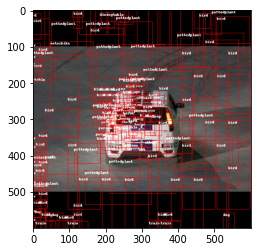

In [ ]:
from PIL import Image

model = RetinaNet().to(device)
model.load_state_dict(torch.load('/content/models/weights.pt'))
model.eval()

# test set trainforms 적용
IMAGE_SIZE = 600
scale = 1.0

test_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensor()
                    ])
# test 이미지 불러오기
img = Image.open('/content/voc/VOCdevkit/VOC2007/JPEGImages/000012.jpg')
w = h = 600
img = np.array(img.convert('RGB'))
img = test_transforms(image=img)
img = img['image']

x = img.unsqueeze(0).to(device) # [batch, H, W, 3]
loc_preds, cls_preds = model(x)

encoder = DataEncoder()
loc_preds, cls_preds = loc_preds.to('cpu'), cls_preds.to('cpu')

# nms 수행 및 출력 값을 바운딩박스 형태로 받아오기
boxes, labels = encoder.decode(loc_preds.data.squeeze(), cls_preds.data.squeeze(), (w,h))

# 이미지 출력
img = transforms.ToPILImage()(img)
draw = ImageDraw.Draw(img)

for box, label in zip(boxes,labels):
    id_ = int(label)
    name = classes[id_]
    draw.rectangle(list(box), outline='red')
    draw.text((box[0], box[1]), name, fill=(255,255,255,0))

plt.imshow(np.array(img))
